In [1]:

import argparse
import os
import subprocess
import sys

import healpy as hp
import matplotlib.pylab as plt
import numpy as np
import rubin_scheduler
import rubin_scheduler.scheduler.basis_functions as bf
import rubin_scheduler.scheduler.detailers as detailers
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.utils import iers
from rubin_scheduler.scheduler import sim_runner
from rubin_scheduler.scheduler.model_observatory import ModelObservatory
from rubin_scheduler.scheduler.schedulers import CoreScheduler, SimpleFilterSched
from rubin_scheduler.scheduler.surveys import (
    BlobSurvey,
    GreedySurvey,
    LongGapSurvey,
    ScriptedSurvey,
    generate_ddf_scheduled_obs,
)
from rubin_scheduler.scheduler.utils import (
    ConstantFootprint,
    EuclidOverlapFootprint,
    make_rolling_footprints,
)
from rubin_scheduler.site_models import Almanac
from rubin_scheduler.utils import _hpid2_ra_dec

%matplotlib inline

In [2]:
mjd_start = 60796.0
nslice=2
rolling_scale=0.9
nside=32

In [3]:


# Modify the footprint
sky = EuclidOverlapFootprint(nside=nside, smc_radius=4, lmc_radius=6)
footprints_hp_array, labels = sky.return_maps()

wfd_indx = np.where(
    (labels == "lowdust") | (labels == "LMC_SMC") | (labels == "virgo")
)[0]
wfd_footprint = footprints_hp_array["r"] * 0
wfd_footprint[wfd_indx] = 1

footprints_hp = {}
for key in footprints_hp_array.dtype.names:
    footprints_hp[key] = footprints_hp_array[key]

footprint_mask = footprints_hp["r"] * 0
footprint_mask[np.where(footprints_hp["r"] > 0)] = 1

repeat_night_weight = None

# Use the Almanac to find the position of the sun at the start of survey
almanac = Almanac(mjd_start=mjd_start)
sun_moon_info = almanac.get_sun_moon_positions(mjd_start)
sun_ra_start = sun_moon_info["sun_RA"].copy()

footprints = make_rolling_footprints(
    fp_hp=footprints_hp,
    mjd_start=mjd_start,
    sun_ra_start=sun_ra_start,
    nslice=nslice,
    scale=rolling_scale,
    nside=nside,
    wfd_indx=wfd_indx,
    order_roll=1,
    n_cycles=4,
)

In [4]:
footprints_uniform = make_rolling_footprints(
    fp_hp=footprints_hp,
    mjd_start=mjd_start,
    sun_ra_start=sun_ra_start,
    nslice=nslice,
    scale=rolling_scale,
    nside=nside,
    wfd_indx=wfd_indx,
    order_roll=1,
    n_cycles=None,
    uniform=True
)

In [5]:
help(footprints.estimate_counts)

Help on method estimate_counts in module rubin_scheduler.scheduler.utils.footprints:

estimate_counts(mjd, nvisits=2200000.0, fov_area=9.6) method of rubin_scheduler.scheduler.utils.footprints.Footprints instance
    Estimate the counts we'll get after some time and visits



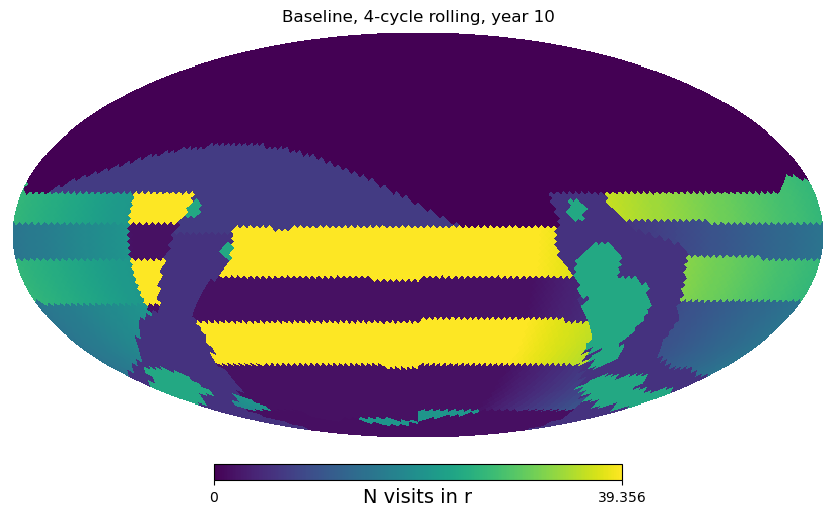

In [6]:
nv=2.1e6
y10_baseline = footprints.estimate_counts(mjd_start+3652, nvisits=nv)['r'] -  footprints.estimate_counts(mjd_start+3652-365.25, nvisits=nv*9/10)['r']
hp.mollview(y10_baseline, title='Baseline, 4-cycle rolling, year 10', unit='N visits in r')

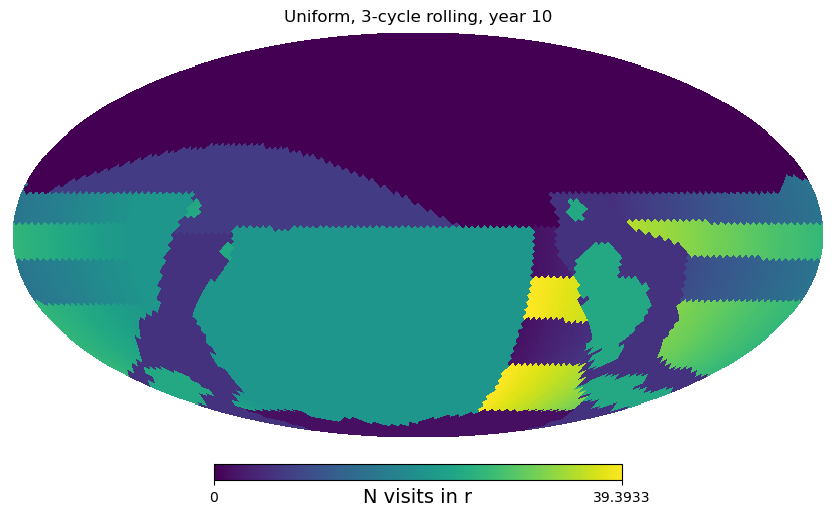

In [7]:
y10_baseline = footprints_uniform.estimate_counts(mjd_start+3652, nvisits=nv)['r'] -  footprints_uniform.estimate_counts(mjd_start+3652-365.25, nvisits=nv*9/10)['r']
hp.mollview(y10_baseline, title='Uniform, 3-cycle rolling, year 10', unit='N visits in r')

In [8]:
footprints = make_rolling_footprints(
    fp_hp=footprints_hp,
    mjd_start=mjd_start,
    sun_ra_start=sun_ra_start,
    nslice=nslice,
    scale=rolling_scale,
    nside=nside,
    wfd_indx=wfd_indx,
    order_roll=1,
    n_cycles=3,
)



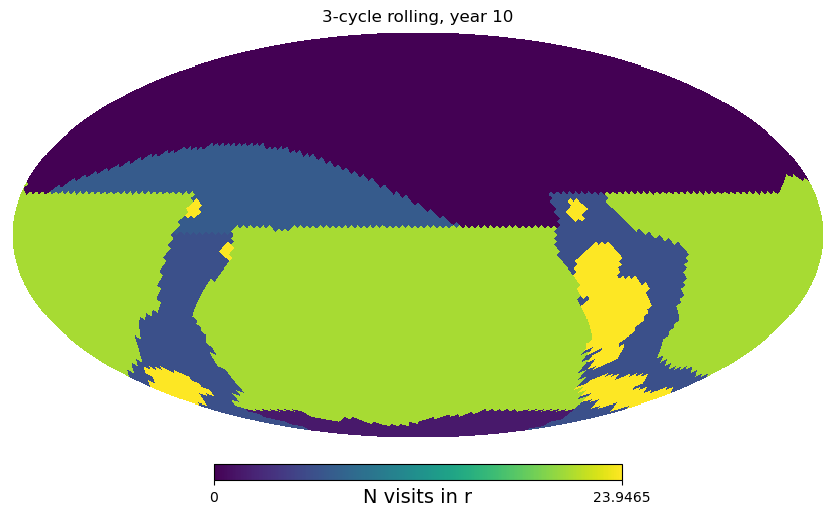

In [9]:
y10_baseline = footprints.estimate_counts(mjd_start+3652, nvisits=nv)['r'] -  footprints.estimate_counts(mjd_start+3652-365.25, nvisits=nv*9/10)['r']
hp.mollview(y10_baseline, title='3-cycle rolling, year 10', unit='N visits in r')